In [2]:
import astropy
import astropy.units as u
from astropy.io import fits
from astropy import constants as const
import numpy as np
import speclite.filters
import pylab as plt
from scipy.ndimage import gaussian_filter1d

In [3]:
filters = speclite.filters.load_filters(
    'cfht_megacam-u', 'cfht_megacam-g',
    'decamDR1-g', 'suprime-IB427',
)

In [4]:
def read_uves_spectrum(fn):
    hdu = fits.open(fn)[0]
    hdr = hdu.header
    sky_flux = hdu.data
    crpix, crval, cdelt = hdr['CRPIX1'], hdr['CRVAL1'], hdr['CDELT1']
    sky_pix = (1 + np.arange(len(sky_flux)))
    sky_wave = crval + (sky_pix - crpix) * cdelt
    return sky_wave, sky_flux

In [5]:
wave1,flux1 = read_uves_spectrum('fluxed_sky_346.fits')
wave2,flux2 = read_uves_spectrum('fluxed_sky_437.fits')
wave3,flux3 = read_uves_spectrum('fluxed_sky_580L.fits')

In [6]:
split12 = 3760.
split23 = 4850.
I1 = (wave1 < split12)
I2 = (wave2 >= split12) * (wave2 < split23)
I3 = (wave3 >= split23)
sky_wave = np.hstack((wave1[I1], wave2[I2], wave3[I3]))
sky_flux = np.hstack((flux1[I1], flux2[I2], flux3[I3]))

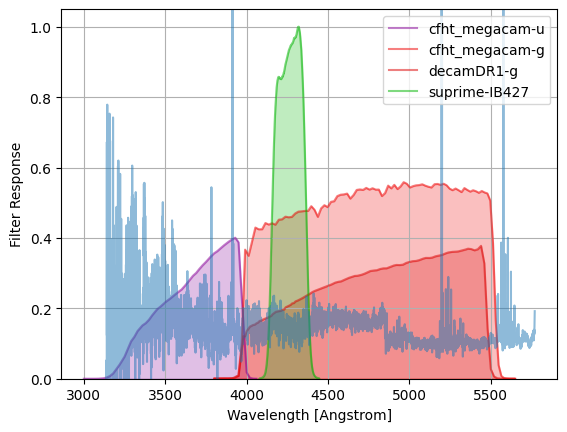

In [7]:
speclite.filters.plot_filters(filters)
plt.plot(sky_wave, gaussian_filter1d(sky_flux, 5), alpha=0.5);

In [8]:
# The UVES sky fluxes are in 1e-16 erg/(s A cm^2 arcs^2)
sky_wave_u = sky_wave * u.Angstrom
# per arcsec^2
sky_flux_u = sky_flux * 1e-16 * u.erg / (u.cm**2 * u.s * u.Angstrom)

In [150]:
# Convert sky spectrum to photons per second on CFHT:
tel_diam = 3.5 * u.m
pixel_size = 0.185 # arcsec

# Energy of a photon of wavelength sky_wave_u
wave_ergs = (const.h.cgs * const.c.cgs / sky_wave_u).to('erg')
tel_area = (np.pi * (tel_diam / 2.)**2).to('cm^2')

dwave = np.diff(sky_wave_u)
dwave = np.append(dwave, [dwave[-1]])

photon_rate = sky_flux_u * dwave * tel_area / wave_ergs * pixel_size**2

In [151]:
# Read CFHT data tables...
def read_table(fn, wavelengths, sep=None, wave_scale=10., trans_scale=0.01):
    f = open(fn)
    qe = []
    for line in f.readlines():
        words = line.strip().split(sep=sep)
        #if len(words) != 2:
        #    continue
        try:
            f1,f2 = float(words[0]), float(words[1])
        except:
            continue
        qe.append([wave_scale * f1, trans_scale * f2])
    qe = np.array(qe)
    if wavelengths is None:
        return qe
    qe_wave = qe[:,0] * u.Angstrom
    qe_frac = qe[:,1]
    qe = np.interp(wavelengths, qe_wave, qe_frac)
    return qe

In [152]:
# From CFHT - QE_camera.dat
qe = read_table('QE_camera.dat', sky_wave_u)
# Optics_TR.dat
optics = read_table('Optics_TR.dat', sky_wave_u)
# Mirror - Al_coating.dat
mirror = read_table('Al_coating.dat', sky_wave_u)
# Filters - 
u_filt = read_table('cfh9302.dat', sky_wave_u, sep=',')
g_filt = read_table('cfh9402.dat', sky_wave_u, sep=',')
cahk_filt = read_table('cfh9303.dat', sky_wave_u, sep=',')

# Fake a flat-topped M4112 filter.
m4112_filt = 0.92 * (sky_wave_u >= 4004*u.Angstrom) * (sky_wave_u <= 4262.8*u.Angstrom)

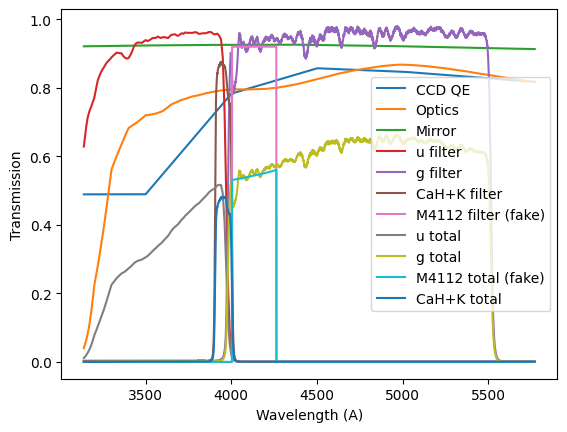

In [153]:
plt.plot(sky_wave_u, qe, label='CCD QE');
plt.plot(sky_wave_u, optics, label='Optics');
plt.plot(sky_wave_u, mirror, label='Mirror');
plt.plot(sky_wave_u, u_filt, label='u filter');
plt.plot(sky_wave_u, g_filt, label='g filter');
plt.plot(sky_wave_u, cahk_filt, label='CaH+K filter');
plt.plot(sky_wave_u, m4112_filt, label='M4112 filter (fake)');

u_tot = qe * optics * mirror * u_filt
g_tot = qe * optics * mirror * g_filt
cahk_tot = qe * optics * mirror * cahk_filt
m4112_tot = qe * optics * mirror * m4112_filt
plt.plot(sky_wave_u, u_tot, label='u total');
plt.plot(sky_wave_u, g_tot, label='g total');
plt.plot(sky_wave_u, m4112_tot, label='M4112 total (fake)');
plt.plot(sky_wave_u, cahk_tot, label='CaH+K total');
plt.xlabel('Wavelength (A)')
plt.ylabel('Transmission')
plt.legend();

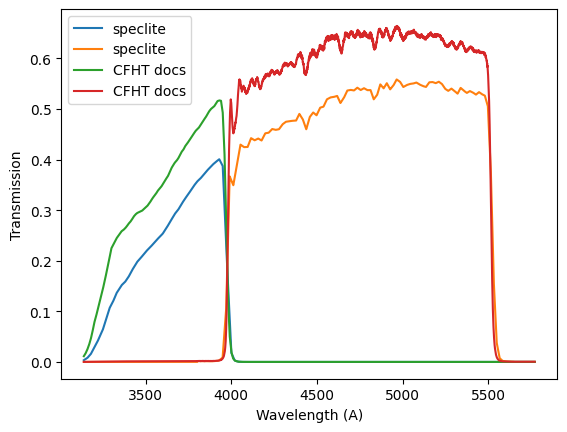

In [154]:
# The transmission curves I'm getting for CFHT are in line with what SpecLite is giving --
# Speclite includes attenuation from 1.25 airmasses also.

plt.plot(sky_wave_u, filters[0].interpolator(sky_wave_u), label='speclite');
plt.plot(sky_wave_u, filters[1].interpolator(sky_wave_u), label='speclite');
plt.plot(sky_wave_u, u_tot, label='CFHT docs');
plt.plot(sky_wave_u, g_tot, label='CFHT docs');
plt.xlabel('Wavelength (A)')
plt.ylabel('Transmission')
plt.legend();

In [155]:
# Speclite docs -- CFHT --
# The response is the total transmission, including the full telescope transmission (mirror+optics+CCD)
# plus 1.25 airmasses of atmospheric attenuation.

for fname,sl,cf in [('g', filters[1], g_tot), ('u', filters[0], u_tot), 
                    ('CaH+K', None, cahk_tot), ('M4112', None, m4112_tot)]:
    photons_cf = np.sum(photon_rate * cf)
    print()
    print(fname)
    print('  CFHT tables:               %6.3f photons/sec' % photons_cf.value)
    if sl is None:
        continue
    photons_sl = np.sum(photon_rate * sl.interpolator(sky_wave_u))
    print('  Speclite (%s): %6.3f photons/sec' % (sl.name, photons_sl.value))
    print('  ratio: %.3g' % (photons_sl / photons_cf))


g
  CFHT tables:                9.868 photons/sec
  Speclite (cfht_megacam-g):  8.213 photons/sec
  ratio: 0.832

u
  CFHT tables:                2.608 photons/sec
  Speclite (cfht_megacam-u):  1.846 photons/sec
  ratio: 0.708

CaH+K
  CFHT tables:                0.440 photons/sec

M4112
  CFHT tables:                1.444 photons/sec


In [156]:
# However, the CFHT Exposure Time Calculator has these numbers:

# CFHT ETC "dark_sky" in e-/s/pixel:
{ 'u' : 0.58, 'g' : 3.34, 'CaHK' : 0.22 }

# "grey sky":
{ 'u' :2.34, 'g' :6.68, 'CaHK':0.45 };

In [157]:
ref_mag = 20.
ref = speclite.filters.ab_reference_flux(sky_wave_u, magnitude=ref_mag)

In [158]:
src1 = np.zeros(len(sky_wave_u))
i = np.argmin(np.abs(sky_wave_u - 4112.*u.Angstrom))
src1[i] = (1e-16 / dwave[i].value)
src1 = src1 * sky_flux_u.unit

In [160]:
#plt.plot(sky_wave_u, ref);
#plt.plot(sky_wave_u, src1)

In [161]:
min(sky_wave_u.value)

3140.00752835

In [162]:
pad_sky_wave_u = np.append([3000.], sky_wave_u.value) * u.Angstrom
pad_sky_flux_u = np.append([0.], sky_flux_u.value) * sky_flux_u.unit
pad_sky_flux_u.unit

Unit("erg / (Angstrom cm2 s)")

In [163]:
mags = filters.get_ab_magnitudes(pad_sky_flux_u, pad_sky_wave_u)

In [164]:
mags

cfht_megacam-u,cfht_megacam-g,decamDR1-g,suprime-IB427
float64,float64,float64,float64
21.781604756526626,21.4010469891792,21.3973249075907,21.532740584039654


In [165]:
ref_photon_rate = ref * dwave * tel_area / wave_ergs * pixel_size**2

In [166]:
ref_photons_g = np.sum(ref_photon_rate * g_tot)

In [167]:
ref_photons_g, photons_g

(<Quantity 35.9237758 1 / s>, <Quantity 10.55320763 1 / s>)

In [168]:
photon_rate = sky_flux_u * dwave * tel_area / wave_ergs * pixel_size**2

In [169]:
photons_g = np.sum(photon_rate * g_tot)

In [170]:
g_mag = ref_mag -2.5 * np.log10(photons_g / ref_photons_g)
g_mag

<Quantity 21.4028721>

In [171]:
# (same as quantity above)

In [172]:
# Note that the sky flux was originally in /arcsec^2 units; we're scaling both ref_photon_rate and photon_rate by
# pixel_size**2 here, so those cancel out.  Same with telescope area!

In [174]:
fudge = 10.**((22.0 - 21.78) / -2.5)
fudge

0.8165823713585932

In [175]:
for fname,tot in [('g', g_tot), ('u', u_tot), ('CaH+K', cahk_tot), ('M4112', m4112_tot)]:
    ref_photons = np.sum(ref_photon_rate * tot)
    photons = np.sum(photon_rate * tot) * fudge
    mag = ref_mag -2.5 * np.log10(photons / ref_photons)
    print('Sky brightness for %6s' % fname, ': %.2f mag/arcsec^2' % mag)

Sky brightness for      g : 21.62 mag/arcsec^2
Sky brightness for      u : 22.00 mag/arcsec^2
Sky brightness for  CaH+K : 21.94 mag/arcsec^2
Sky brightness for  M4112 : 21.79 mag/arcsec^2


In [176]:
for fname,tot in [('g', g_tot), ('u', u_tot), ('CaH+K', cahk_tot), ('M4112', m4112_tot)]:
    ref_photons = np.sum(ref_photon_rate * tot)
    photon_rate = src1 * dwave * tel_area / wave_ergs * pixel_size**2
    photons = np.sum(photon_rate * tot)
    mag = ref_mag -2.5 * np.log10(photons / ref_photons)
    print('Brightness for %6s' % fname, ': %.2f mag' % mag)


Brightness for      g : 27.45 mag
Brightness for      u : 38.19 mag
Brightness for  CaH+K : 31.78 mag
Brightness for  M4112 : 25.55 mag


In [177]:
#decam_sky = read_table('spec-sky.dat', sky_wave_u, wave_scale=1., trans_scale=1.)
decam_sky = read_table('spec-sky-cut.dat', None, wave_scale=1., trans_scale=1.)
decam_wave_u = decam_sky[:,0] * u.Angstrom
decam_flux_u = decam_sky[:,1] * 1e-17 * sky_flux_u.unit
decam_flux_u.unit

Unit("erg / (Angstrom cm2 s)")

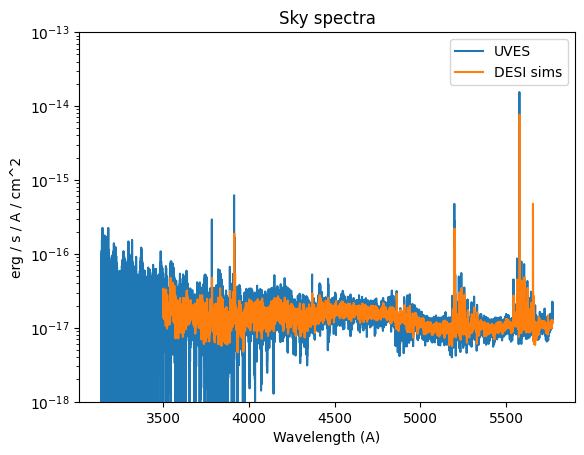

In [178]:
plt.plot(sky_wave_u, sky_flux_u, label='UVES');
plt.plot(decam_wave_u, decam_flux_u, label='DESI sims');
plt.yscale('log')
plt.ylim(1e-18, 1e-13)
plt.ylabel('erg / s / A / cm^2');
plt.xlabel('Wavelength (A)')
plt.title('Sky spectra')
plt.legend()
plt.savefig('sky.png')

In [203]:
# Convert sky spectrum to photons per second on CFHT:
# Energy of a photon of wavelength sky_wave_u
decam_wave_ergs = (const.h.cgs * const.c.cgs / decam_wave_u).to('erg')

decam_dwave = np.diff(decam_wave_u)
decam_dwave = np.append(decam_dwave, [decam_dwave[-1]])

decam_photon_rate = decam_flux_u * decam_dwave * tel_area / decam_wave_ergs * pixel_size**2

decam_ref = speclite.filters.ab_reference_flux(decam_wave_u, magnitude=ref_mag)
decam_ref_photon_rate = decam_ref * decam_dwave * tel_area / decam_wave_ergs * pixel_size**2

# Re-read CFHT data tables to interpolate onto the decam_wave_u grid
d_qe = read_table('QE_camera.dat', decam_wave_u)
d_optics = read_table('Optics_TR.dat', decam_wave_u)
d_mirror = read_table('Al_coating.dat', decam_wave_u)
d_u_filt = read_table('cfh9302.dat', decam_wave_u, sep=',')
d_g_filt = read_table('cfh9402.dat', decam_wave_u, sep=',')
d_cahk_filt = read_table('cfh9303.dat', decam_wave_u, sep=',')
# Fake a flat-topped M4112 filter.
d_m4112_filt = 0.92 * (decam_wave_u >= 4004*u.Angstrom) * (decam_wave_u <= 4262.8*u.Angstrom)
d_tel = d_qe * d_optics * d_mirror
d_u_tot = d_tel * d_u_filt
d_g_tot = d_tel * d_g_filt
d_cahk_tot = d_tel * d_cahk_filt
d_m4112_tot = d_tel * d_m4112_filt

for fname,tot in [('g', d_g_tot), ('u', d_u_tot), ('CaH+K', d_cahk_tot), ('M4112', d_m4112_tot)]:
    ref_photons = np.sum(decam_ref_photon_rate * tot)
    photons = np.sum(decam_photon_rate * tot)
    mag = ref_mag -2.5 * np.log10(photons / ref_photons)
    print('Sky brightness for %6s' % fname, ': %.2f mag/arcsec^2' % mag)

Sky brightness for      g : 21.40 mag/arcsec^2
Sky brightness for      u : 21.80 mag/arcsec^2
Sky brightness for  CaH+K : 21.71 mag/arcsec^2
Sky brightness for  M4112 : 21.57 mag/arcsec^2


In [180]:
decam_fudge = 10.**((22.0 - 21.80) / -2.5)
decam_fudge

0.8317637711026715

In [ ]:
# Let's count photons from a source, find NEA, and SNR!

In [200]:
seeing = 0.8 # arcsec FWHM
sig = seeing / 2.35 # arcsec
nea_gal = 4.*np.pi * (sig**2 + (pixel_size**2/12.) + 0.35**2) # in arcsec^2
ne_gauss = 2.35 * np.sqrt(nea_gal / (4.*np.pi))
nea_psf = 4.*np.pi * sig**2 # arcsec^2
nea_gal_pix = nea_gal / (pixel_size**2) # in pixels
nea_psf_pix = nea_psf / (pixel_size**2) # in pixels
nea_gal, nea_psf, ne_gauss, nea_gal_pix, nea_psf_pix

(3.0315316813450117,
 1.4563109448963096,
 1.1542343263862556,
 88.57652830810845,
 42.5510867756409)

88.57575468078421

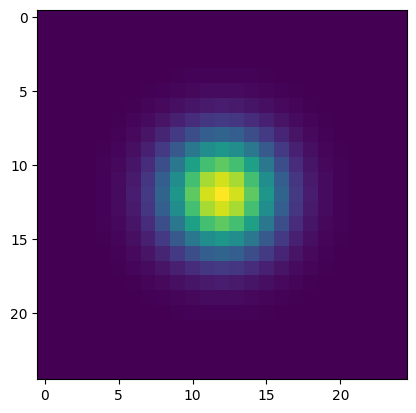

In [201]:
xx,yy = np.meshgrid(np.arange(25), np.arange(25))
rr = np.hypot(xx - 12, yy-12)
#psf = np.exp(-rr**2 / (2. * (sig/pixel_size)**2))
psf = np.exp(-rr**2 / (2. * (ne_gauss / 2.35 / pixel_size)**2))
psf /= np.sum(psf)
plt.imshow(psf)
psfnorm = np.sqrt(np.sum(psf**2))
# NEA
(1./psfnorm)**2

In [199]:
# Target S/N of source detection
snr = 5.

In [139]:
d_src1 = np.zeros(len(decam_wave_u))
i = np.argmin(np.abs(decam_wave_u - 4112.*u.Angstrom))
d_src1[i] = (1e-16 / decam_dwave[i].value)
d_src1 = d_src1 * decam_flux_u.unit

In [206]:
src = d_src1
for fname,tot in [('M4112', d_m4112_tot)]:

    src_photon_rate = src * decam_dwave * tel_area / decam_wave_ergs
    src_photon_rate = np.sum(src_photon_rate * tot)
    print('Total source count rate for %6s' % fname, ': ', src_photon_rate)

    sky_photon_rate = decam_fudge * decam_flux_u * decam_dwave * tel_area / decam_wave_ergs * pixel_size**2
    sky_photon_rate = np.sum(sky_photon_rate * tot)
    print('Sky photon rate per pixel:', sky_photon_rate)

    ref_photon_rate = np.sum(decam_ref_photon_rate * tot)
    mag = ref_mag -2.5 * np.log10(sky_photon_rate / ref_photon_rate)
    print('Sky brightness for %6s' % fname, ': %.2f mag/arcsec^2' % mag)
    
    mag = ref_mag -2.5 * np.log10(src_photon_rate * (pixel_size**2) / ref_photon_rate)
    print('Source brightness for %6s' % fname, ': %.2f mag' % mag)
    
    print('Sky photon rate for NEA (Galaxy):', sky_photon_rate * nea_gal_pix)
    print('Sky photon rate for NEA (PSF):', sky_photon_rate * nea_psf_pix)

    t_galaxy = snr**2 * (sky_photon_rate * nea_gal_pix) / src_photon_rate**2
    t_psf = snr**2 * (sky_photon_rate * nea_psf_pix) / src_photon_rate**2
    
    print('Exposure time for galaxy:', t_galaxy)
    print('Exposure time for PSF:', t_psf)

Total source count rate for  M4112 :  1.078416004414099 1 / s
Sky photon rate per pixel: 1.204541254155723 1 / s
Sky brightness for  M4112 : 21.77 mag/arcsec^2
Source brightness for  M4112 : 25.55 mag
Sky photon rate for NEA (Galaxy): 106.69408249700885 1 / s
Sky photon rate for NEA (PSF): 51.254539430419484 1 / s
Exposure time for galaxy: 2293.547256753442 s
Exposure time for PSF: 1101.7922039874643 s
